# Moscow Housing

[Kaggle Competition](https://www.kaggle.com/c/moscow-housing-tdt4173/)

This notebook has been made with reproducibility in mind, and all results should be exactly reproducible as far as possible. We do note that this means training/optimization must be done sequentially, not concurrently as supported by e.g. Optuna, due to the intrinsic nature of concurrent operations.

## Setup

Load Python packages and data.

- `catboost`
- `contextily`
- `geopandas`
- `lightgbm`
- `numpy`
- `optuna`
- `pandas`
- `seaborn`
- `sklearn`
- `xgboost`

In [1]:
import io

# Load Python packages
import catboost
import contextily as cx
import geopandas as gpd
import lightgbm as lgb
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import sklearn.metrics
import xgboost as xgb

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Use an SQLite database for persistent Optuna storage, replace with `None` to
# use in-memory storage
STORAGE = "sqlite:///resources/vegard_optuna.sqlite"

In [4]:
# Read the apartment datasets
apartments_train = pd.read_csv("resources/data/apartments_train.csv").set_index("id")
apartments_train["split"] = "train"
apartments_test = pd.read_csv("resources/data/apartments_test.csv").set_index("id")
apartments_test["split"] = "test"

# Create a DataFrame of all apartments
apartments = pd.concat([apartments_train, apartments_test])

# Read the building datasets
buildings_train = pd.read_csv("resources/data/buildings_train.csv").set_index("id")
buildings_train["split"] = "train"
buildings_test = pd.read_csv("resources/data/buildings_test.csv").set_index("id")
buildings_test["split"] = "test"

# Create a GeoDataFrame of all buildings
buildings = pd.concat([buildings_train, buildings_test])
buildings = gpd.GeoDataFrame(buildings, geometry=gpd.points_from_xy(
    buildings.longitude, buildings.latitude, crs="EPSG:4326"
))

## Helpers

In [5]:
def rmsle(y_true, y_pred):
    """Root Mean Squared Logarithmic Error"""
    return np.sqrt(sklearn.metrics.mean_squared_log_error(y_true, y_pred))

In [6]:
def plot_feature_importances(names, importances, model_name):
    sort_idx = np.argsort(importances)[::-1]
    sns.barplot(
        y=np.array(names)[sort_idx],
        x=importances[sort_idx],
        palette="summer",
    ).set(title=f"{model_name} Feature Importances")

def plot_hyperparameter_importances(study):
    importances = optuna.importance.get_param_importances(study)
    sns.barplot(
        y=list(importances.keys()),
        x=list(importances.values()),
        palette="Oranges_r",
    ).set(title=f"{study.study_name} Hyperparameter Importances")

## Incorrectly positioned buildings

### Missing coordinates

In [7]:
# Find all buildings missing coordinates
no_coords = buildings.latitude.isna() | buildings.longitude.isna()
buildings[no_coords][[
    "split", "latitude", "longitude", "district", "street", "address",
    "constructed", "material", "stories"
]]

,split,latitude,longitude,district,street,address,constructed,material,stories
id,,,,,,,,,
3803,test,NaN,NaN,NaN,пос. Коммунарка,Москва А101 ЖК,2019.0,2.0,12.0


There's only one building with missing coordinates, and by looking at the address we assume it to be located in Moscow.

In [8]:
# Find other buildings on the same street
street = buildings[~no_coords & (buildings.street == "пос. Коммунарка")]
street[[
    "split", "latitude", "longitude", "district", "street", "address",
    "constructed", "material", "stories"
]]

,split,latitude,longitude,district,street,address,constructed,material,stories
id,,,,,,,,,
2036,train,55.569133,37.474408,11.0,пос. Коммунарка,22,2013.0,NaN,14.0
2461,train,55.571632,37.473492,11.0,пос. Коммунарка,20,2011.0,NaN,17.0
6375,train,55.567285,37.477929,11.0,пос. Коммунарка,17,1994.0,3.0,12.0
6280,train,55.572986,37.475189,11.0,пос. Коммунарка,4,1963.0,4.0,5.0
8577,train,55.570843,37.473635,11.0,пос. Коммунарка,20А,2012.0,NaN,17.0
6200,test,55.560891,37.473761,11.0,пос. Коммунарка,101,2020.0,0.0,16.0


Checking the rest of our data we find multiple buildings on the same street. There is even another building in the test dataset with an address number containing 101, though we do not assume these to be the same building due to differing values in the other columns of the dataset.

We set the missing location information be taking the median location of each known building on the same street and the most common district number (only 11).

In [9]:
# Set the location and district for the building with missing coordinates
buildings.loc[no_coords, "latitude"] = street.latitude.mean()
buildings.loc[no_coords, "longitude"] = street.longitude.mean()
buildings.loc[no_coords, "district"] = street.district.mode()[0]

print("There are now", (buildings.latitude.isna() | buildings.longitude.isna()).sum(), "buildings with missing coordinates.")

There are now 0 buildings with missing coordinates.


### Buildings with coordinates outside of Moscow

In [10]:
# The coordinates of the southwest and northeast corners of a rectangle approximately encompassing Moscow
MOSCOW_SW_LAT = 55.101131
MOSCOW_SW_LON = 36.754394
MOSCOW_NE_LAT = 56.117476
MOSCOW_NE_LON = 38.218283

In [11]:
# Find all buildings with coordinates outside of Moscow
outside = (((buildings.latitude < MOSCOW_SW_LAT) | (buildings.latitude > MOSCOW_NE_LAT))
          & ((buildings.longitude < MOSCOW_SW_LON) | (buildings.longitude > MOSCOW_NE_LON)))
buildings[outside][[
    "split", "latitude", "longitude", "district", "street", "address",
    "constructed", "material", "stories"
]]

,split,latitude,longitude,district,street,address,constructed,material,stories
id,,,,,,,,,
5667,test,43.352968,132.759204,NaN,улица Центральная,48,NaN,NaN,2.0
4412,test,17.141734,-61.790500,NaN,Бунинские Луга ЖК,к2/2/2,2021.0,NaN,9.0
4202,test,42.914700,74.517184,NaN,улица 1-я Линия,57,2016.0,NaN,3.0
8811,test,43.353545,132.768097,NaN,улица Центральная,75,2007.0,NaN,5.0
4636,test,17.141734,-61.790500,NaN,Бунинские Луга ЖК,к2/2/1,2021.0,3.0,17.0


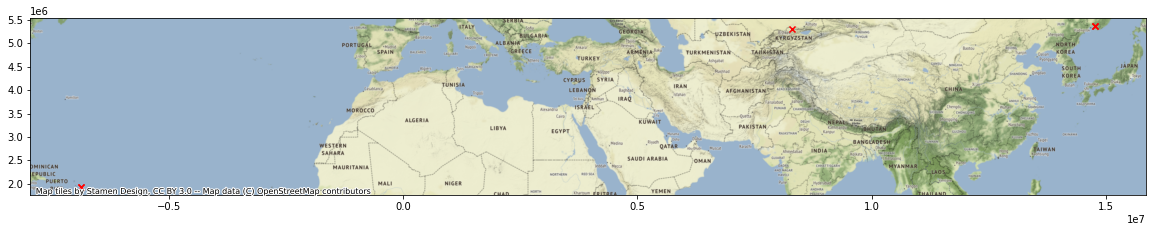

In [12]:
# Plot the buildings outside of Moscow on a map
ax = buildings[outside].to_crs(epsg=3857).plot(figsize=(20, 10), marker="x", color="r")
cx.add_basemap(ax)

We note that all the buildings with missing coordinates are in the test set and have seemingly Russian name, indicating that these may be data entry errors and the buildings may actually be located inside Moscow.

In [13]:
# Find the number of buildings in the dataset on the same street
streets = buildings[outside].street.unique()
pd.DataFrame(
    index=streets,
    data={
        "test": map(
            lambda street: len(buildings[
                ~outside
                & (buildings.split == "test")
                & (buildings.street == street)
            ]),
            streets
        ),
        "train": map(
            lambda street: len(buildings[
                ~outside
                & (buildings.split == "train")
                & (buildings.street == street)
            ]),
            streets
        ),
    },
)

,test,train
улица Центральная,8,16
Бунинские Луга ЖК,1,8
улица 1-я Линия,0,0


Looking at the number of buildings on the same street in our dataset, we find that two of the streets have multiple other buildings. For these we use the mean location of the buildings on that street and the most common district. For the remaining street without any other buildings we place it at the mean location of all known buildings inside Moscow.

In [14]:
# Set the location (and district) of the buildings with coordinates outside of Moscow
for idx, building in buildings[outside].iterrows():
    street = buildings[~outside & (buildings.street == building.street)]
    if len(street):
        buildings.loc[idx, "latitude"] = street.latitude.mean()
        buildings.loc[idx, "longitude"] = street.longitude.mean()
        buildings.loc[idx, "district"] = street.district.mode()[0]
    else:
        buildings.loc[idx, "latitude"] = buildings[~outside].latitude.mean()
        buildings.loc[idx, "longitude"] = buildings[~outside].longitude.mean()

print("There are now", (((buildings.latitude < MOSCOW_SW_LAT) | (buildings.latitude > MOSCOW_NE_LAT)) & ((buildings.longitude < MOSCOW_SW_LON) | (buildings.longitude > MOSCOW_NE_LON))).sum(), "buildings outside of Moscow")

There are now 0 buildings outside of Moscow


### Missing `district`

In [15]:
# Find all buildings missing a district
no_district = buildings.district.isna()
buildings[no_district][["split", "latitude", "longitude", "district", "street", "address", "constructed", "material", "stories"]]

,split,latitude,longitude,district,street,address,constructed,material,stories
id,,,,,,,,,
4162,train,55.595160,37.741109,NaN,23-й км,5к1,2021.0,3.0,9.0
1647,test,55.595160,37.741109,NaN,23-й км,7к1,2018.0,NaN,25.0
6403,test,55.595160,37.741109,NaN,23-й км,11к1,2019.0,NaN,16.0
7317,test,55.583551,37.711356,NaN,25-й км,вл1с1,NaN,NaN,13.0
2265,test,55.595160,37.741109,NaN,23-й км,13к2,2018.0,NaN,25.0
926,test,55.921627,37.781578,NaN,В мкр,37,1989.0,2.0,16.0
6879,test,55.932127,37.793705,NaN,В мкр,30,1975.0,2.0,9.0
4202,test,55.727684,37.592893,NaN,улица 1-я Линия,57,2016.0,NaN,3.0
183,test,55.595160,37.741109,NaN,23-й км,11к2,2019.0,NaN,25.0


Since all buildings now have approximate coordinates inside of Moscow, we copy the district from the closest building (Manhattan distance).

In [16]:
# For each building with district missing, copy the district from the closest building
# Closest here is the smallest coordinate difference
districts = buildings.loc[no_district].apply(
    lambda b: buildings.loc[
        (buildings[~no_district][["latitude", "longitude"]] - b[["latitude", "longitude"]]).abs().sum(axis=1).idxmin()
    ].district,
    axis=1
)
districts.rename("district", inplace=True)
buildings.update(districts)

print("There are now", buildings.district.isna().sum(), "buildings with district missing")

There are now 0 buildings with district missing


## Nearest POIs

The distance to nearby points of interest (POI) may affect the price of an apartment. To capture this effect, we compute the distance to nearby metro stations, parks and gardens, and public squares.

Distance is calculated using the haversine formula and is given in meters.

In [17]:
# The Earth's radius in meters
EARTH_RADIUS = 6371000

# Create columns for coordinates given in radians to avoid having to recalculate
buildings["lat_rad"] = np.radians(buildings.latitude)
buildings["lon_rad"] = np.radians(buildings.longitude)

### Metro Stations

Station location data downloaded from [_List of Moscow Metro stations_](https://en.wikipedia.org/wiki/List_of_Moscow_Metro_stations) on Wikipedia.

The provided KML file has been converted to a CSV for inline inclusion in the notebook.

In [18]:
STATIONS_CSV = """
name,latitude,longitude
Bulvar Rokossovskogo (Sokolnicheskaya line),55.8148,37.7342
Cherkizovskaya,55.8038,37.7448
Preobrazhenskaya Ploshchad,55.7963,37.7151
Sokolniki,55.7888,37.6802
Krasnoselskaya,55.7801,37.6673
Komsomolskaya (Sokolnicheskaya line),55.7753,37.6562
Krasnye Vorota,55.769,37.6487
Chistye Prudy,55.7657,37.6388
Lubyanka,55.7597,37.6272
Okhotny Ryad,55.7577,37.6166
Biblioteka Imeni Lenina,55.7512,37.61
Kropotkinskaya,55.7453,37.6037
Park Kultury (Sokolnicheskaya line),55.7356,37.5943
Frunzenskaya,55.7267,37.5786
Sportivnaya,55.7233,37.5639
Vorobyovy Gory,55.7103,37.5592
Universitet,55.6926,37.5333
Prospekt Vernadskogo,55.6771,37.506
Yugo-Zapadnaya,55.6637,37.4833
Troparyovo,55.6459,37.4725
Rumyantsevo,55.633,37.4419
Salaryevo,55.6227,37.424
Filatov Lug,55.601367,37.407645
Prokshino,55.586242,37.433802
Olkhovaya,55.568643,37.459332
Kommunarka,55.560396,37.46822
Khovrino,55.8791,37.4822
Belomorskaya,55.8658,37.4764
Rechnoy Vokzal,55.8549,37.4761
Vodny Stadion,55.8398,37.4867
Voykovskaya,55.819,37.498
Sokol,55.8051,37.5153
Aeroport,55.8003,37.5329
Dinamo,55.7897,37.558
Belorusskaya (Zamoskvoretskaya line),55.7767,37.5835
Mayakovskaya,55.7701,37.5958
Tverskaya,55.7647,37.6065
Teatralnaya,55.7578,37.619
Novokuznetskaya,55.7415,37.6295
Paveletskaya (Zamoskvoretskaya line),55.7305,37.6377
Avtozavodskaya (Zamoskvoretskaya line),55.7074,37.6576
Tekhnopark (Moscow Metro),55.695,37.6641
Kolomenskaya (Moscow Metro),55.6785,37.6638
Kashirskaya,55.6551,37.6487
Kantemirovskaya,55.6358,37.6564
Tsaritsyno,55.6214,37.6694
Orekhovo,55.6132,37.6949
Domodedovskaya,55.6108,37.7186
Krasnogvardeyskaya,55.6137,37.7444
Alma-Atinskaya,55.6326,37.766
Pyatnitskoye Shosse,55.8563,37.3544
Mitino,55.8457,37.3622
Volokolamskaya,55.8354,37.3822
Myakinino,55.8252,37.3852
Strogino,55.8038,37.4031
Krylatskoye,55.7567,37.4081
Molodyozhnaya,55.7408,37.4168
Kuntsevskaya,55.7307,37.4459
Slavyansky Bulvar,55.7296,37.4706
Park Pobedy,55.7362,37.5182
Kiyevskaya (Arbatsko-Pokrovskaya line),55.7442,37.5645
Smolenskaya (Arbatsko-Pokrovskaya line),55.7474,37.5823
Arbatskaya (Arbatsko-Pokrovskaya line),55.7522,37.6061
Ploshchad Revolyutsii,55.7566,37.6216
Kurskaya (Arbatsko-Pokrovskaya line),55.7576,37.6577
Baumanskaya,55.773,37.6806
Elektrozavodskaya,55.7817,37.7037
Semyonovskaya,55.7833,37.7208
Partizanskaya,55.7886,37.7506
Izmaylovskaya,55.7878,37.7814
Pervomayskaya,55.7948,37.7993
Shchyolkovskaya,55.8094,37.7986
Pionerskaya,55.736,37.4671
Filyovsky Park,55.7396,37.4833
Bagrationovskaya,55.7438,37.4977
Fili,55.746,37.515
Kutuzovskaya,55.7399,37.5344
Studencheskaya,55.7388,37.5483
Mezhdunarodnaya,55.7483,37.5339
Vystavochnaya,55.7502,37.5408
Kiyevskaya (Filyovskaya line),55.7436,37.5655
Smolenskaya (Filyovskaya line),55.7488,37.5825
Arbatskaya (Filyovskaya line),55.7518,37.6007
Aleksandrovsky Sad,55.7525,37.6085
Kiyevskaya (Koltsevaya line),55.7446,37.5644
Krasnopresnenskaya,55.7613,37.5774
Belorusskaya (Koltsevaya line),55.7764,37.5844
Novoslobodskaya,55.7799,37.6028
Prospekt Mira (Koltsevaya line),55.7798,37.6318
Komsomolskaya (Koltsevaya line),55.7748,37.6549
Kurskaya (Koltsevaya line),55.757,37.6595
Taganskaya (Koltsevaya line),55.7418,37.6517
Paveletskaya (Koltsevaya line),55.7318,37.6379
Dobryninskaya,55.7291,37.6243
Oktyabrskaya (Koltsevaya line),55.7297,37.6091
Park Kultury (Koltsevaya line),55.7357,37.5915
Medvedkovo,55.8872,37.6613
Babushkinskaya,55.8694,37.6644
Sviblovo,55.8552,37.6527
Botanichesky Sad,55.8449,37.6383
VDNKh,55.8211,37.6411
Alekseyevskaya,55.8088,37.639
Rizhskaya,55.7936,37.6362
Prospekt Mira (Kaluzhsko-Rizhskaya line),55.7812,37.6318
Sukharevskaya,55.7733,37.6319
Turgenevskaya,55.7661,37.6374
Kitay-gorod,55.7553,37.6333
Tretyakovskaya,55.7412,37.6274
Oktyabrskaya (Kaluzhsko-Rizhskaya line),55.7306,37.6112
Shabolovskaya,55.7198,37.6083
Leninsky Prospekt,55.7077,37.5861
Akademicheskaya (Moscow Metro),55.6877,37.5733
Profsoyuznaya,55.678,37.5627
Novye Cheryomushki,55.6702,37.5544
Kaluzhskaya,55.6571,37.5405
Belyayevo,55.6428,37.5257
Konkovo,55.6333,37.5188
Tyoply Stan,55.6191,37.5082
Yasenevo,55.6063,37.5333
Novoyasenevskaya,55.601,37.5541
Planernaya,55.8607,37.4364
Skhodnenskaya,55.8505,37.4396
Tushinskaya,55.8267,37.4368
Spartak,55.8182,37.4352
Shchukinskaya,55.8086,37.4641
Oktyabrskoye Pole,55.7935,37.4935
Polezhayevskaya,55.7775,37.5192
Begovaya,55.7738,37.5468
Ulitsa 1905 Goda,55.765,37.5613
Barrikadnaya,55.7612,37.5795
Pushkinskaya,55.765,37.6079
Kuznetsky Most,55.7606,37.6259
Taganskaya (Tagansko-Krasnopresnenskaya line),55.7402,37.6522
Proletarskaya,55.7319,37.6659
Volgogradsky Prospekt,55.7253,37.6869
Tekstilshchiki,55.7088,37.7316
Kuzminki,55.7056,37.7656
Ryazansky Prospekt,55.717,37.7933
Vykhino,55.7156,37.8181
Lermontovsky Prospekt,55.7013,37.8525
Zhulebino,55.6855,37.8563
Kotelniki,55.6743,37.8582
Rasskazovka,55.6339,37.3347
Novoperedelkino,55.6396,37.3552
Borovskoye Shosse,55.6476,37.3701
Solntsevo,55.6493,37.3909
Govorovo,55.6595,37.4172
Ozyornaya,55.6709,37.4491
Michurinsky Prospekt,55.6896,37.4833
Ramenki,55.6975,37.4984
Lomonosovsky Prospekt,55.7069,37.5156
Minskaya,55.7246,37.497
Delovoy Tsentr,55.7475,37.5319
Marksistskaya,55.7411,37.6543
Ploshchad Ilyicha,55.7472,37.6824
Aviamotornaya (Kalininsko-Solntsevskaya line),55.7524,37.7191
Shosse Entuziastov,55.7576,37.75
Perovo,55.7511,37.7866
Novogireyevo,55.7517,37.8166
Novokosino,55.7451,37.8638
Altufyevo,55.898,37.587
Bibirevo,55.8838,37.6034
Otradnoye,55.8633,37.6047
Vladykino (Moscow Central Circle),55.8473,37.5899
Petrovsko-Razumovskaya,55.8351,37.5745
Timiryazevskaya,55.8176,37.5765
Dmitrovskaya,55.8069,37.5817
Savyolovskaya,55.7927,37.5885
Mendeleyevskaya,55.781,37.6011
Tsvetnoy Bulvar,55.7708,37.6187
Chekhovskaya,55.7644,37.6097
Borovitskaya,55.7511,37.6072
Polyanka,55.7379,37.618
Serpukhovskaya,55.728,37.6246
Tulskaya,55.7087,37.6229
Nagatinskaya,55.683,37.6224
Nagornaya,55.6724,37.6104
Nakhimovsky Prospekt,55.6627,37.6055
Sevastopolskaya,55.6524,37.5984
Chertanovskaya,55.6405,37.6067
Yuzhnaya,55.6224,37.609
Prazhskaya,55.6124,37.6044
Ulitsa Akademika Yangelya,55.5949,37.6004
Annino,55.5828,37.5966
Bulvar Dmitriya Donskogo,55.5693,37.5769
Seligerskaya,55.865,37.548333
Verkhnie Likhobory,55.855833,37.561111
Okruzhnaya,55.846,37.57425
Fonvizinskaya,55.8228,37.5881
Butyrskaya,55.8133,37.6028
Maryina Roshcha (Lyublinsko–Dmitrovskaya line),55.7954,37.6162
Dostoyevskaya,55.7816,37.6151
Trubnaya,55.7688,37.62
Sretensky Bulvar,55.7668,37.6392
Chkalovskaya,55.7565,37.6573
Rimskaya,55.7463,37.6819
Krestyanskaya Zastava,55.7331,37.6673
Dubrovka,55.7186,37.676
Kozhukhovskaya,55.7074,37.6851
Pechatniki (Lyublinsko–Dmitrovskaya line),55.6934,37.727
Volzhskaya,55.6909,37.753
Lyublino,55.6758,37.7618
Bratislavskaya,55.6597,37.7505
Maryino,55.65,37.7431
Borisovo,55.6334,37.7436
Shipilovskaya,55.6211,37.7437
Zyablikovo,55.6124,37.7453
Mnyovniki,55.7585,37.4708
Narodnoye Opolcheniye,55.7738,37.4844
Shelepikha,55.7567,37.526
Khoroshyovskaya,55.7768,37.5207
"CSKA[[Category:All articles with links needing disambiguation]][[Category:Articles with links needing disambiguation from April 2021]]<sup class=""noprint Inline-Template "" style=""white-space:nowrap;"">&#91;<i>[[Wikipedia:WikiProject Disambiguation/Fixing links|<span title=""Link needs disambiguation&#32;(April 2021)"">disambiguation needed</span>]]</i>&#93;</sup>",55.7866,37.5333
Petrovsky park,55.7918,37.5571
Savyolovskaya,55.7936,37.588
Bittsevsky Park,55.6004,37.5562
Lesoparkovaya,55.5821,37.5769
Ulitsa Starokachalovskaya,55.569,37.5767
Ulitsa Skobelevskaya,55.5481,37.5546
Bulvar Admirala Ushakova,55.5455,37.543
Ulitsa Gorchakova,55.5418,37.5308
Buninskaya Alleya,55.538,37.5158
Timiryazevskaya,55.819,37.5789
Ulitsa Milashenkova,55.8218,37.5911
Teletsentr,55.8218,37.6089
Ulitsa Akademika Korolyova,55.8218,37.6269
Vystavochny Tsentr,55.824,37.6383
Ulitsa Sergeya Eisensteina,55.8292,37.6449
Okruzhnaya,55.8472,37.5694
Vladykino,55.8476,37.593
Botanichesky Sad,55.846,37.6413
Rostokino,55.84,37.6653
Belokamennaya,55.83,37.7006
Bulvar Rokossovskogo (Moscow Central Circle),55.8172,37.7369
Lokomotiv,55.8039,37.746
Izmaylovo,55.7886,37.7428
Sokolinaya Gora,55.7714,37.7451
Shosse Entuziastov,55.759,37.7463
Andronovka,55.7411,37.7344
Nizhegorodskaya,55.7322,37.7282
Novokhokhlovskaya,55.7239,37.7161
Ugreshskaya,55.7183,37.6978
Avtozavodskaya (Moscow Central Circle),55.7063,37.6631
ZIL (Moscow Central Circle),55.6983,37.6483
Verkhnie Kotly,55.69,37.6189
Krymskaya,55.69,37.605
Ploshchad Gagarina,55.7069,37.5858
Luzhniki,55.7203,37.5631
Kutuzovskaya,55.7408,37.5333
Delovoy Tsentr,55.7472,37.5322
Shelepikha,55.7575,37.5256
Khoroshyovo,55.7772,37.5072
Zorge,55.7878,37.5045
Panfilovskaya,55.7991,37.4988
Streshnevo,55.8136,37.4869
Baltiyskaya,55.8258,37.4961
Koptevo,55.8397,37.5203
Likhobory,55.8472,37.5513
Elektrozavodskaya,55.780292,37.703013
Lefortovo,55.764738,37.706747
Aviamotornaya,55.75367,37.719149
Nizhegorodskaya,55.731748,37.730076
Stakhanovskaya,55.725,37.7619
Okskaya,55.7186,37.7817
Yugo-Vostochnaya,55.70497,37.81901
Kosino,55.7033,37.8511
Ulitsa Dmitriyevskogo,55.71,37.8792
Lukhmanovskaya,55.7085,37.9004
Nekrasovka,55.7036,37.9264
"""

In [19]:
# Read the metro station location data into a DataFrame
stations = pd.read_csv(io.StringIO(STATIONS_CSV))

# Create columns for the coordinates given in radians
stations["lat_rad"] = np.radians(stations.latitude)
stations["lon_rad"] = np.radians(stations.longitude)

stations

,name,latitude,longitude,lat_rad,lon_rad
0,Bulvar Rokossovskogo (Sokolnicheskaya line),55.81480,37.73420,0.974152,0.658586
1,Cherkizovskaya,55.80380,37.74480,0.973960,0.658771
2,Preobrazhenskaya Ploshchad,55.79630,37.71510,0.973829,0.658253
3,Sokolniki,55.78880,37.68020,0.973698,0.657644
4,Krasnoselskaya,55.78010,37.66730,0.973546,0.657418
...,...,...,...,...,...
263,Yugo-Vostochnaya,55.70497,37.81901,0.972235,0.660066
264,Kosino,55.70330,37.85110,0.972206,0.660626
265,Ulitsa Dmitriyevskogo,55.71000,37.87920,0.972323,0.661117
266,Lukhmanovskaya,55.70850,37.90040,0.972297,0.661487


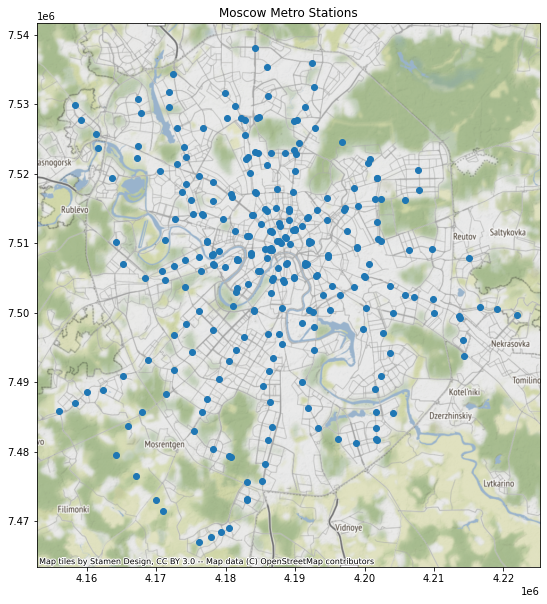

In [20]:
# Plot the location of each metro station on a map
ax = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(
    stations.longitude, stations.latitude, crs="EPSG:4326"
)).to_crs(epsg=3857).plot(figsize=(10, 10))
ax.set_title("Moscow Metro Stations")
cx.add_basemap(ax)

Add a `metro_distance` feature to `buildings` for the distance to the nearest metro station in meters.

In [21]:
# Calculate the distance to the nearest metro station for each building using
# the haversine formula with the Earth's radius as given above
buildings["metro_distance"] = buildings.apply(
    lambda row: np.min(
        2
        * EARTH_RADIUS
        * np.arcsin(
            np.sqrt(
                np.sin((stations.lat_rad - row.lat_rad) / 2) ** 2
                + np.cos(row.lat_rad)
                * np.cos(stations.lat_rad)
                * np.sin((stations.lon_rad - row.lon_rad) / 2) ** 2
            )
        )
    ),
    axis=1,
)

### Parks and Gardens

Park and garden data downloaded from [_Category:Parks and gardens in Moscow_](https://en.wikipedia.org/wiki/Category:Parks_and_gardens_in_Moscow) on Wikipedia.

The provided KML file has been converted to a CSV for inline inclusion in the notebook.

In [22]:
PARKS_CSV = """
name,latitude,longitude
Alexander Garden,55.7525,37.6138888888889
Bitsa Park,55.6175,37.567
Clean Ponds,55.7608333433,37.6447222322
Fallen Monument Park,55.7327777777778,37.6052777777778
Gorky Park (Moscow),55.7283333333333,37.6
Izmaylovo Estate,55.7916666666667,37.7622222222222
Izmaylovo Estate,55.8011111111111,37.7691666666667
Izmaylovo Estate,55.7994444444444,37.7502777777778
Izmaylovo Estate,55.7744444444444,37.7861111111111
Izmaylovo Estate,55.7719444444444,37.8172222222222
Izmaylovo Estate,55.7844444444444,37.7697222222222
Izmaylovo Estate,55.7719444444444,37.7675
Izmaylovo Estate,55.7927777777778,37.8355555555556
Izmaylovsky Park,55.777,37.789
Kolomenskoye,55.6694444444444,37.6688888888889
Lebedyansky Ponds,55.7756,37.8078
Losiny Ostrov National Park,55.8636111111111,37.7775
Lyublino Park,55.689,37.747
"Manezhnaya Square, Moscow",55.7558333333333,37.6147222222222
Memorial park complex of the heroes of the First World War,55.7997222222222,37.5125555555556
Moscow Botanical Garden of Academy of Sciences,55.839,37.601
Moscow Hermitage Garden,55.7711111111111,37.6075
Neskuchny Garden,55.7161,37.5881
Patriarch Ponds,55.763883,37.59212
Poklonnaya Hill,55.7316666666667,37.5066666666667
Sadovniki (park),55.6619444444444,37.6538888888889
"Sechenov Botanical Garden, First Moscow State Medical University",55.746928,37.530171
Serebryany Bor (park),55.7805555555556,37.4161111111111
Sokolniki Park,55.8005555555556,37.6697222222222
Taynitsky Garden,55.7502777777778,37.6205555555556
Tsaritsyno Palace,55.615,37.6819444444444
Vlakhernskoye-Kuzminki,55.6894444444444,37.785
Zaryadye Park,55.751,37.629
"""

In [23]:
# Read the parks and gardens location data into a DataFrame
parks = pd.read_csv(io.StringIO(PARKS_CSV))

# Create columns for the coordinates given in radians
parks["lat_rad"] = np.radians(parks.latitude)
parks["lon_rad"] = np.radians(parks.longitude)

parks

,name,latitude,longitude,lat_rad,lon_rad
0,Alexander Garden,55.752500,37.613889,0.973065,0.656486
1,Bitsa Park,55.617500,37.567000,0.970708,0.655668
2,Clean Ponds,55.760833,37.644722,0.973210,0.657024
3,Fallen Monument Park,55.732778,37.605278,0.972720,0.656336
4,Gorky Park (Moscow),55.728333,37.600000,0.972643,0.656244
5,Izmaylovo Estate,55.791667,37.762222,0.973748,0.659075
6,Izmaylovo Estate,55.801111,37.769167,0.973913,0.659196
7,Izmaylovo Estate,55.799444,37.750278,0.973884,0.658867
8,Izmaylovo Estate,55.774444,37.786111,0.973448,0.659492
9,Izmaylovo Estate,55.771944,37.817222,0.973404,0.660035


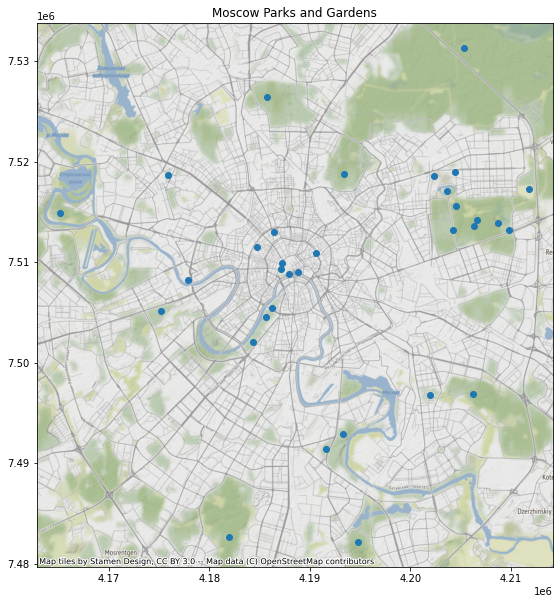

In [24]:
# Plot the location of each park and garden on a map
ax = gpd.GeoDataFrame(parks, geometry=gpd.points_from_xy(
    parks.longitude, parks.latitude, crs="EPSG:4326"
)).to_crs(epsg=3857).plot(figsize=(10, 10))
ax.set_title("Moscow Parks and Gardens")
cx.add_basemap(ax)

Add a `park_distance` feature to `buildings` for the distance to the nearest park or garden in meters.

In [25]:
# Calculate the distance to the nearest park or garden for each building using
# the haversine formula with the Earth's radius as given above
buildings["park_distance"] = buildings.apply(
    lambda row: np.min(
        2
        * EARTH_RADIUS
        * np.arcsin(
            np.sqrt(
                np.sin((parks.lat_rad - row.lat_rad) / 2) ** 2
                + np.cos(row.lat_rad)
                * np.cos(parks.lat_rad)
                * np.sin((parks.lon_rad - row.lon_rad) / 2) ** 2
            )
        )
    ),
    axis=1,
)

### Squares

Square data downloaded from [_Category:Squares in Moscow_](https://en.wikipedia.org/wiki/Category:Squares_in_Moscow) on Wikipedia.

The provided KML file has been converted to a CSV for inline inclusion in the notebook.

In [26]:
SQUARES_CSV = """
name,latitude,longitude
Arbatskaya Square,55.7519,37.6011
Bolotnaya Square,55.745,37.6175
"Cathedral Square, Moscow",55.7505555656,37.61750001
Ivanovskaya Square,55.7516,37.6188
Josip Broz Tito Square,55.6780555555556,37.5633333333333
Komsomolskaya Square (Moscow),55.775,37.6541666666667
Krestyanskaya Zastava Square,55.7325,37.6692
Lubyanka Square,55.7594444444444,37.6269444444444
"Manezhnaya Square, Moscow",55.7558333333333,37.6147222222222
Pushkinskaya Square,55.7655555555556,36.6225
Pushkinskaya Square,55.7655555555556,37.6058333333333
Red Square,55.7541666666667,37.62
"Revolution Square, Moscow",55.7575,37.6197222222222
Slavyanskaya Square,55.75389,37.63304
Smolenskaya Square,55.7478888989,37.5824722322
Square of Europe,55.7438888888889,37.5694444444444
Square of Europe,55.7438,37.5694
Staraya Square,55.7555555656,37.6305555656
Suvorov Square (Moscow),55.7813,37.6161
Taganka Square,55.7402777777778,37.6525
Theatre Square (Moscow),55.7591666666667,37.6188888888889
Triumfalnaya Square,55.77,37.5958
Universitetskaya Square,55.70662,37.53745
"""

In [27]:
# Read the squares location data into a DataFrame
squares = pd.read_csv(io.StringIO(SQUARES_CSV))

# Create columns for the coordinates given in radians
squares["lat_rad"] = np.radians(squares.latitude)
squares["lon_rad"] = np.radians(squares.longitude)

squares

,name,latitude,longitude,lat_rad,lon_rad
0,Arbatskaya Square,55.751900,37.601100,0.973054,0.656263
1,Bolotnaya Square,55.745000,37.617500,0.972934,0.656549
2,"Cathedral Square, Moscow",55.750556,37.617500,0.973031,0.656549
3,Ivanovskaya Square,55.751600,37.618800,0.973049,0.656572
4,Josip Broz Tito Square,55.678056,37.563333,0.971765,0.655604
5,Komsomolskaya Square (Moscow),55.775000,37.654167,0.973457,0.657189
6,Krestyanskaya Zastava Square,55.732500,37.669200,0.972716,0.657452
7,Lubyanka Square,55.759444,37.626944,0.973186,0.656714
8,"Manezhnaya Square, Moscow",55.755833,37.614722,0.973123,0.656501
9,Pushkinskaya Square,55.765556,36.622500,0.973293,0.639183


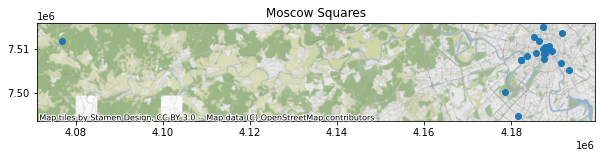

In [28]:
# Plot the location of each square on a map
ax = gpd.GeoDataFrame(squares, geometry=gpd.points_from_xy(
    squares.longitude, squares.latitude, crs="EPSG:4326"
)).to_crs(epsg=3857).plot(figsize=(10, 10))
ax.set_title("Moscow Squares")
cx.add_basemap(ax)

Add a `square_distance` feature to `buildings` for the distance to the nearest square in meters.

In [29]:
# Calculate the distance to the nearest square for each building using the
# haversine formula with the Earth's radius as given above
buildings["square_distance"] = buildings.apply(
    lambda row: np.min(
        2
        * EARTH_RADIUS
        * np.arcsin(
            np.sqrt(
                np.sin((squares.lat_rad - row.lat_rad) / 2) ** 2
                + np.cos(row.lat_rad)
                * np.cos(squares.lat_rad)
                * np.sin((squares.lon_rad - row.lon_rad) / 2) ** 2
            )
        )
    ),
    axis=1,
)

### Cleanup

Drop temporary columns and variables.

In [30]:
del EARTH_RADIUS, 
del STATIONS_CSV, PARKS_CSV, SQUARES_CSV
del stations, parks, squares

buildings.drop(columns=["lat_rad", "lon_rad"], inplace=True)

## Estimate construction year

**Idea:** Estimate `constructed` using `street` and/or `district`.

In [31]:
# Find the mean and median construction year for each district
district_constructed_mean = buildings.groupby("district").constructed.mean().round()
district_constructed_median = buildings.groupby("district").constructed.median().round()

In [32]:
# Find the mean and median construction year for each street
street_constructed_mean = buildings.groupby("street").constructed.mean().round().dropna()
street_constructed_median = buildings.groupby("street").constructed.median().round().dropna()

In [33]:
# Print the error of the different estimation techniques compared to the known values
idx = ~buildings.constructed.isna()
pd.DataFrame.from_dict({
    "District Mean": sklearn.metrics.mean_absolute_error(
        buildings[idx].constructed,
        buildings[idx].district.map(lambda d: district_constructed_mean[d]),
    ),
    "District Median": sklearn.metrics.mean_absolute_error(
        buildings[idx].constructed,
        buildings[idx].district.map(lambda d: district_constructed_median[d]),
    ),
    "Street Mean": sklearn.metrics.mean_absolute_error(
        buildings[idx].constructed,
        buildings[idx].street.map(lambda s: street_constructed_mean[s]),
    ),
    "Street Median": sklearn.metrics.mean_absolute_error(
        buildings[idx].constructed,
        buildings[idx].street.map(lambda s: street_constructed_median[s]),
    ),
}, orient="index", columns=["Mean Absolute Error"])

,Mean Absolute Error
District Mean,18.276681
District Median,17.787553
Street Mean,10.048702
Street Median,8.980142


The best estimator seems to be the median construction year of all the buildings on the same street. Unfortunately, there are some streets where none of the buildings have known construction dates, for these we fall back to the median construction year of the district.

In [34]:
# Add estimates for the buildings with missing constructions years
buildings.loc[~idx, "constructed"] = buildings[~idx].apply(
    lambda b: street_constructed_median[b.street]
              if b.street in street_constructed_median
              else district_constructed_median[b.district],
    axis=1
)
print("There are now", buildings.constructed.isna().sum(), "buildings with a missing construction year")

There are now 0 buildings with a missing construction year


## Ceiling

In [35]:
idx = apartments.ceiling > 50
pd.DataFrame(apartments.ceiling[idx].describe())

,ceiling
count,31.000000
mean,294.838710
std,27.793401
min,250.000000
25%,267.500000
50%,300.000000
75%,317.500000
max,350.000000


Looking at `apartments` we see 31 with a ceiling higher than 50m. Inspecting the data, we find it likely that these are data entry error, i.e. that the data has been entered in centimeters instead of meters.

In [36]:
apartments["ceiling_fix"] = apartments.ceiling
apartments.loc[idx, "ceiling_fix"] = apartments.ceiling[idx] / 100

## Merge

Merges `apartments` and `buildings` into a single dataframe.

In [37]:
# Merge while making sure we're keeping the correct index
data = apartments.reset_index().merge(
    buildings, how="left", left_on=["building_id", "split"], right_on=["id", "split"]
).set_index("id")

## Extra features

Create more features on the merged dataset.

In [38]:
data["ballog"] = data.balconies + data.loggias

In [39]:
data["bathrooms_total"] = data.bathrooms_private + data.bathrooms_shared

In [40]:
data["log_price_per_sqm"] = np.log(data.price / data.area_total)

In [41]:
data["log_area_total"] = np.log(data.area_total)

## Export preprocessed data

In [42]:
data.drop(columns=["geometry"]).to_csv("resources/vegard_preprocessed.csv")

## Split

Splits the training and testing sets.

In [43]:
data_train = data[data.split == "train"].copy()
data_test = data[data.split == "test"].copy()

## LightGBM-F4

In [44]:
LIGHTGBM_F4_FEATURES = [
    "latitude", "longitude", "district", "constructed", "area_total", "rooms",
    "ballog", "metro_distance", "park_distance", "square_distance", "material",
    "condition", "heating", "stories", "floor", "ceiling", "bathrooms_total",
    "new",
]
LIGHTGBM_F4_CATEGORICAL_FEATURES = [
    "district", "material", "condition", "heating", "new",
]

In [45]:
def lightgbm_f4_objective(trial):
    params = {
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0),
        "colsample_bytree": trial.suggest_categorical("colsample_bytree", [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        "subsample": trial.suggest_categorical("subsample", [0.4, 0.5, 0.6, 0.7, 0.8, 1.0]),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.006, 0.008, 0.01, 0.014, 0.017, 0.02, 0.03]),
        "max_depth": trial.suggest_int("max_depth", 1, 250),
        "num_leaves": trial.suggest_int("num_leaves", 2, 1000),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 300),
        "cat_smooth": trial.suggest_int("cat_smooth", 3, 60),
    }

    kf = sklearn.model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

    model = lgb.LGBMRegressor(random_state=42, metric="rmse", n_estimators=5000, n_jobs=3, **params)

    scores = []
    for train_idx, test_idx in kf.split(data_train[LIGHTGBM_F4_FEATURES], data_train.price):
        train, test = data_train.iloc[train_idx], data_train.iloc[test_idx]

        model.fit(
            train[LIGHTGBM_F4_FEATURES],
            train.log_price_per_sqm,
            categorical_feature=LIGHTGBM_F4_CATEGORICAL_FEATURES
        )

        predictions = np.exp(model.predict(test[LIGHTGBM_F4_FEATURES])) * test.area_total
        scores.append(rmsle(test.price, predictions))

    return np.mean(scores)

In [46]:
lightgbm_f4_study = optuna.create_study(
    storage=STORAGE,
    sampler=optuna.samplers.TPESampler(seed=42),
    study_name="LightGBM-F4",
    direction="minimize",
    load_if_exists=True
)

if not lightgbm_f4_study.trials:
    lightgbm_f4_study.optimize(lightgbm_f4_objective, n_trials=10)
else:
    print("Some trials have already been run, skipping further optimization.")

[I 2021-11-10 10:25:03,447] Using an existing study with name 'LightGBM-F4' instead of creating a new one.


Some trials have already been run, skipping further optimization.


In [47]:
pd.DataFrame.from_dict({
    "Number of completed trials": (lightgbm_f4_study.trials_dataframe().state == "COMPLETE").sum(),
    "Best trial": lightgbm_f4_study.best_trial.number,
    "Best value": lightgbm_f4_study.best_value,
}, orient="index", columns=[""])

,
Number of completed trials,100.000000
Best trial,84.000000
Best value,0.118117


In [48]:
pd.DataFrame.from_dict(lightgbm_f4_study.best_params, orient="index", columns=["Value"])

,Value
cat_smooth,21.000000
colsample_bytree,0.400000
learning_rate,0.010000
max_depth,156.000000
min_child_samples,8.000000
num_leaves,204.000000
reg_alpha,0.002358
reg_lambda,0.007413
subsample,0.400000


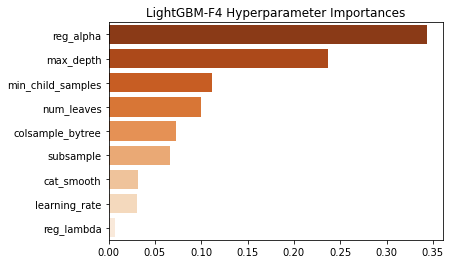

In [49]:
plot_hyperparameter_importances(lightgbm_f4_study)

In [50]:
lightgbm_f4_model = lgb.LGBMRegressor(metric="rmse", n_estimators=5000, random_state=42, **lightgbm_f4_study.best_params)

lightgbm_f4_model.fit(data_train[LIGHTGBM_F4_FEATURES], data_train.log_price_per_sqm)

LGBMRegressor(cat_smooth=21, colsample_bytree=0.4, learning_rate=0.01,
              max_depth=156, metric='rmse', min_child_samples=8,
              n_estimators=5000, num_leaves=204, random_state=42,
              reg_alpha=0.00235801860230238, reg_lambda=0.007412701808093166,
              subsample=0.4)

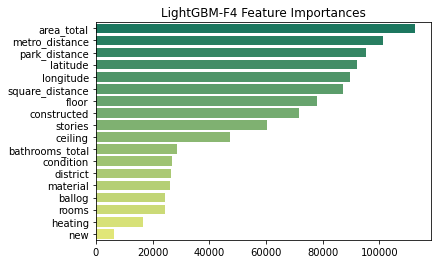

In [51]:
plot_feature_importances(LIGHTGBM_F4_FEATURES, lightgbm_f4_model.feature_importances_, "LightGBM-F4")

In [52]:
# Predict prices for the whole test set and write them to a correctly formatted CSV file
lightgbm_f4_prediction = np.exp(lightgbm_f4_model.predict(data_test[LIGHTGBM_F4_FEATURES])) * data_test.area_total
lightgbm_f4_prediction.rename("price_prediction").to_csv("submissions/lightgbm_f4.csv", index_label="id")

## CatBoost-T2

In [53]:
CATBOOST_T2_FEATURES = LIGHTGBM_F4_FEATURES

In [54]:
def catboost_t2_objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 1, 1000),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
        "depth": trial.suggest_int("depth", 6, 14),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.001, 100.0),
        "random_strength": trial.suggest_int("random_strength", 0, 100),
        "bagging_temperature": trial.suggest_loguniform("bagging_temperature", 0.001, 100.0),
    }

    kf = sklearn.model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

    model = catboost.CatBoostRegressor(objective="RMSE", random_seed=42, silent=True, thread_count=1, **params)

    scores = []
    for train_idx, test_idx in kf.split(data_train[CATBOOST_T2_FEATURES], data_train.price):
        train, test = data_train.iloc[train_idx], data_train.iloc[test_idx]

        model.fit(train[CATBOOST_T2_FEATURES], train.log_price_per_sqm)

        predictions = np.exp(model.predict(test[CATBOOST_T2_FEATURES])) * test.area_total
        scores.append(rmsle(test.price, predictions))

    return np.mean(scores)

In [55]:
catboost_t2_study = optuna.create_study(
    storage=STORAGE,
    sampler=optuna.samplers.TPESampler(seed=42),
    study_name="CatBoost-T2",
    direction="minimize",
    load_if_exists=True
)

if not catboost_t2_study.trials:
    catboost_t2_study.optimize(catboost_t2_objective, n_trials=10)
else:
    print("Some trials have already been run, skipping further optimization.")

[I 2021-11-10 10:28:52,026] Using an existing study with name 'CatBoost-T2' instead of creating a new one.


Some trials have already been run, skipping further optimization.


In [56]:
pd.DataFrame.from_dict({
    "Number of completed trials": (catboost_t2_study.trials_dataframe().state == "COMPLETE").sum(),
    "Best trial": catboost_t2_study.best_trial.number,
    "Best value": catboost_t2_study.best_value,
}, orient="index", columns=[""])

,
Number of completed trials,100.000000
Best trial,86.000000
Best value,0.124684


In [57]:
pd.DataFrame.from_dict(catboost_t2_study.best_params, orient="index", columns=["Value"])

,Value
bagging_temperature,0.007189
depth,8.000000
iterations,915.000000
l2_leaf_reg,0.007295
learning_rate,0.116465
random_strength,23.000000


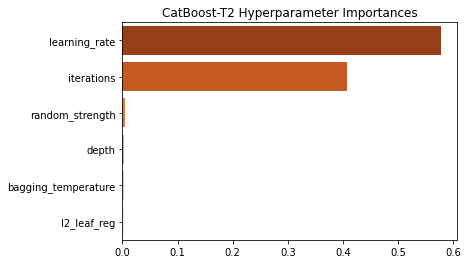

In [58]:
plot_hyperparameter_importances(catboost_t2_study)

In [59]:
catboost_t2_model = catboost.CatBoostRegressor(objective="RMSE", random_seed=42, silent=True, thread_count=1, **catboost_t2_study.best_params)

catboost_t2_model.fit(data_train[CATBOOST_T2_FEATURES], data_train.log_price_per_sqm)

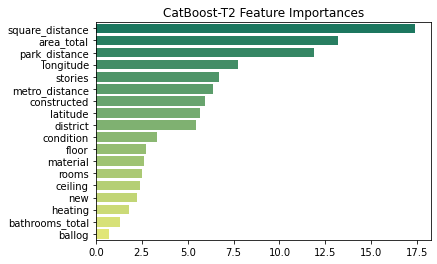

In [60]:
plot_feature_importances(CATBOOST_T2_FEATURES, catboost_t2_model.feature_importances_, "CatBoost-T2")

In [61]:
# Predict prices for the whole test set and write them to a correctly formatted CSV file
catboost_t2_prediction = np.exp(catboost_t2_model.predict(data_test[CATBOOST_T2_FEATURES])) * data_test.area_total
catboost_t2_prediction.rename("price_prediction").to_csv("submissions/catboost_t2.csv", index_label="id")

## Mean of LightGBM-F4 and CatBoost-T2

In [62]:
((lightgbm_f4_prediction + catboost_t2_prediction) / 2).rename("price_prediction").to_csv("submissions/mean_lightgbm_f4_and_catboost_t2.csv", index_label="id")

## XGBoost-P2

In [63]:
XGBOOST_P2_FEATURES = LIGHTGBM_F4_FEATURES

In [64]:
def xgboost_p2_objective(trial):
    params = {
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "eta": trial.suggest_loguniform("eta", 0.001, 0.5),
        "gamma": trial.suggest_loguniform("gamma", 0.00001, 10.0),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 1000),
        "subsample": trial.suggest_loguniform("subsample", 0.1, 1.0),
        "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.1, 1.0),
        "lambda": trial.suggest_loguniform("lambda", 0.00001, 10.0),
        "alpha": trial.suggest_loguniform("alpha", 0.00001, 10.0),
    }

    kf = sklearn.model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

    model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, nthread=3, **params)

    scores = []
    for train_idx, test_idx in kf.split(data_train[XGBOOST_P2_FEATURES], data_train.price):
        train, test = data_train.iloc[train_idx], data_train.iloc[test_idx]

        model.fit(train[XGBOOST_P2_FEATURES], train.log_price_per_sqm)

        predictions = np.exp(model.predict(test[XGBOOST_P2_FEATURES])) * test.area_total
        scores.append(rmsle(test.price, predictions))

    return np.mean(scores)

In [65]:
xgboost_p2_study = optuna.create_study(
    storage=STORAGE,
    sampler=optuna.samplers.TPESampler(seed=42),
    study_name="XGBoost-P2",
    direction="minimize",
    load_if_exists=True
)

if not xgboost_p2_study.trials:
    xgboost_p2_study.optimize(xgboost_p2_objective, n_trials=10)
else:
    print("Some trials have already been run, skipping further optimization.")

[I 2021-11-10 10:29:06,479] Using an existing study with name 'XGBoost-P2' instead of creating a new one.


Some trials have already been run, skipping further optimization.


In [66]:
pd.DataFrame.from_dict({
    "Number of completed trials": (xgboost_p2_study.trials_dataframe().state == "COMPLETE").sum(),
    "Best trial": xgboost_p2_study.best_trial.number,
    "Best value": xgboost_p2_study.best_value,
}, orient="index", columns=[""])

,
Number of completed trials,100.000000
Best trial,89.000000
Best value,0.121779


In [67]:
pd.DataFrame.from_dict(xgboost_p2_study.best_params, orient="index", columns=["Value"])

,Value
alpha,0.000011
booster,dart
colsample_bytree,0.772809
eta,0.077529
gamma,0.000184
lambda,0.017131
max_depth,20
min_child_weight,1
subsample,0.724117


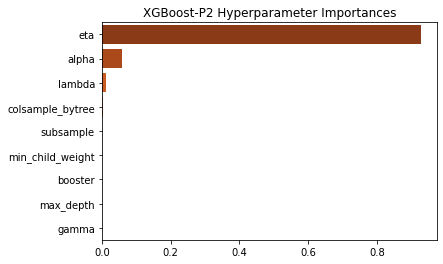

In [68]:
plot_hyperparameter_importances(xgboost_p2_study)

In [69]:
xgboost_p2_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, nthread=3, **xgboost_p2_study.best_params)

xgboost_p2_model.fit(data_train[XGBOOST_P2_FEATURES], data_train.log_price_per_sqm)

XGBRegressor(alpha=1.0688030776681168e-05, base_score=0.5, booster='dart',
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.7728087067630364, enable_categorical=False,
             eta=0.07752935477711576, gamma=0.00018406622479410044, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             lambda=0.017131208303499065, learning_rate=0.0775293559,
             max_delta_step=0, max_depth=20, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=3, nthread=3,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=1.06880307e-05, reg_lambda=0.0171312075,
             scale_pos_weight=1, subsample=0.7241173917439103,
             tree_method='exact', ...)

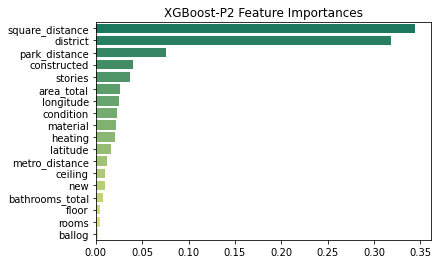

In [70]:
plot_feature_importances(XGBOOST_P2_FEATURES, xgboost_p2_model.feature_importances_, "XGBoost-P2")

In [71]:
# Predict prices for the whole test set and write them to a correctly formatted CSV file
xgboost_p2_prediction = np.exp(xgboost_p2_model.predict(data_test[XGBOOST_P2_FEATURES])) * data_test.area_total
xgboost_p2_prediction.rename("price_prediction").to_csv("submissions/xgboost_p2.csv", index_label="id")

## LightGBM-F4L

Same as LightGBM-F4, but using the logarithm of `area_total`.

In [72]:
LIGHTGBM_F4L_FEATURES = [
    "latitude", "longitude", "district", "constructed", "log_area_total",
    "rooms", "ballog", "metro_distance", "park_distance", "square_distance",
    "material", "condition", "heating", "stories", "floor", "ceiling",
    "bathrooms_total", "new",
]
LIGHTGBM_F4L_CATEGORICAL_FEATURES = [
    "district", "material", "condition", "heating", "new",
]

In [73]:
def lightgbm_f4l_objective(trial):
    params = {
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0),
        "colsample_bytree": trial.suggest_categorical("colsample_bytree", [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        "subsample": trial.suggest_categorical("subsample", [0.4, 0.5, 0.6, 0.7, 0.8, 1.0]),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.006, 0.008, 0.01, 0.014, 0.017, 0.02, 0.03]),
        "max_depth": trial.suggest_int("max_depth", 1, 250),
        "num_leaves": trial.suggest_int("num_leaves", 2, 1000),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 300),
        "cat_smooth": trial.suggest_int("cat_smooth", 3, 60),
    }

    kf = sklearn.model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

    model = lgb.LGBMRegressor(random_state=42, metric="rmse", n_estimators=5000, n_jobs=3, **params)

    scores = []
    for train_idx, test_idx in kf.split(data_train[LIGHTGBM_F4L_FEATURES], data_train.price):
        train, test = data_train.iloc[train_idx], data_train.iloc[test_idx]

        model.fit(
            train[LIGHTGBM_F4L_FEATURES],
            train.log_price_per_sqm,
            categorical_feature=LIGHTGBM_F4L_CATEGORICAL_FEATURES
        )

        predictions = np.exp(model.predict(test[LIGHTGBM_F4L_FEATURES])) * test.area_total
        scores.append(rmsle(test.price, predictions))

    return np.mean(scores)

In [74]:
lightgbm_f4l_study = optuna.create_study(
    storage=STORAGE,
    sampler=optuna.samplers.TPESampler(seed=42),
    study_name="LightGBM-F4L",
    direction="minimize",
    load_if_exists=True
)

if not lightgbm_f4l_study.trials:
    lightgbm_f4l_study.optimize(lightgbm_f4l_objective, n_trials=10)
else:
    print("Some trials have already been run, skipping further optimization.")

[I 2021-11-10 10:29:29,180] Using an existing study with name 'LightGBM-F4L' instead of creating a new one.


Some trials have already been run, skipping further optimization.


In [75]:
pd.DataFrame.from_dict({
    "Number of completed trials": (lightgbm_f4l_study.trials_dataframe().state == "COMPLETE").sum(),
    "Best trial": lightgbm_f4l_study.best_trial.number,
    "Best value": lightgbm_f4l_study.best_value,
}, orient="index", columns=[""])

,
Number of completed trials,100.000000
Best trial,92.000000
Best value,0.118775


In [76]:
pd.DataFrame.from_dict(lightgbm_f4l_study.best_params, orient="index", columns=["Value"])

,Value
cat_smooth,8.000000
colsample_bytree,0.400000
learning_rate,0.010000
max_depth,94.000000
min_child_samples,10.000000
num_leaves,844.000000
reg_alpha,0.178293
reg_lambda,7.885409
subsample,0.500000


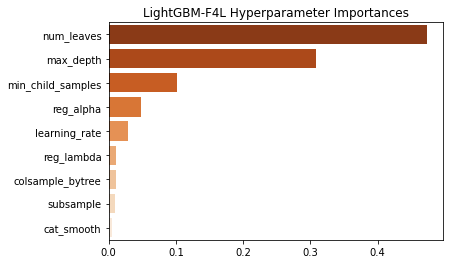

In [77]:
plot_hyperparameter_importances(lightgbm_f4l_study)

In [78]:
lightgbm_f4l_model = lgb.LGBMRegressor(metric="rmse", n_estimators=5000, random_state=42, **lightgbm_f4l_study.best_params)

lightgbm_f4l_model.fit(data_train[LIGHTGBM_F4L_FEATURES], data_train.log_price_per_sqm)

LGBMRegressor(cat_smooth=8, colsample_bytree=0.4, learning_rate=0.01,
              max_depth=94, metric='rmse', min_child_samples=10,
              n_estimators=5000, num_leaves=844, random_state=42,
              reg_alpha=0.17829273729112688, reg_lambda=7.885408928941956,
              subsample=0.5)

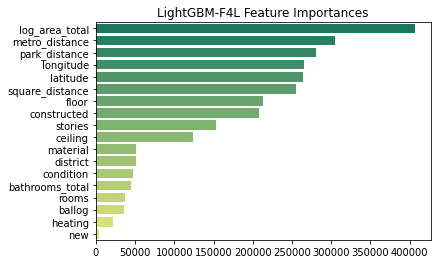

In [79]:
plot_feature_importances(LIGHTGBM_F4L_FEATURES, lightgbm_f4l_model.feature_importances_, "LightGBM-F4L")

In [80]:
# Predict prices for the whole test set and write them to a correctly formatted CSV file
lightgbm_f4l_prediction = np.exp(lightgbm_f4l_model.predict(data_test[LIGHTGBM_F4L_FEATURES])) * data_test.area_total
lightgbm_f4l_prediction.rename("price_prediction").to_csv("submissions/lightgbm_f4l.csv", index_label="id")

## LightGBM-F4L with LightGBM-F4 params

Only experimental.

In [81]:
lightgbm_f4lf4_model = lgb.LGBMRegressor(metric="rmse", n_estimators=5000, **lightgbm_f4_study.best_params)

lightgbm_f4lf4_model.fit(data_train[LIGHTGBM_F4L_FEATURES], data_train.log_price_per_sqm)

LGBMRegressor(cat_smooth=21, colsample_bytree=0.4, learning_rate=0.01,
              max_depth=156, metric='rmse', min_child_samples=8,
              n_estimators=5000, num_leaves=204, reg_alpha=0.00235801860230238,
              reg_lambda=0.007412701808093166, subsample=0.4)

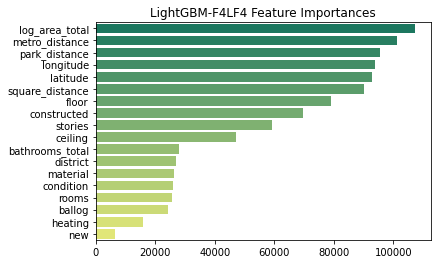

In [82]:
plot_feature_importances(LIGHTGBM_F4L_FEATURES, lightgbm_f4lf4_model.feature_importances_, "LightGBM-F4LF4")

In [83]:
# Predict prices for the whole test set and write them to a correctly formatted CSV file
lightgbm_f4lf4_prediction = np.exp(lightgbm_f4lf4_model.predict(data_test[LIGHTGBM_F4L_FEATURES])) * data_test.area_total
lightgbm_f4lf4_prediction.rename("price_prediction").to_csv("submissions/lightgbm_f4lf4.csv", index_label="id")

<AxesSubplot:xlabel='area_total', ylabel='price'>

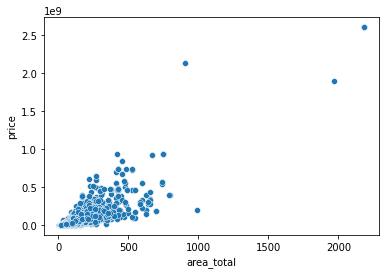

In [84]:
sns.scatterplot(x="area_total", y="price", data=data_train)

<AxesSubplot:xlabel='log_area_total', ylabel='price'>

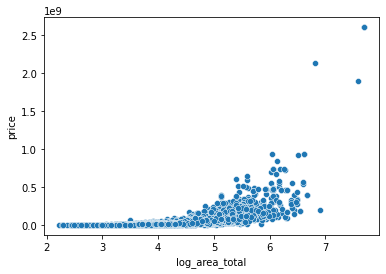

In [85]:
sns.scatterplot(x="log_area_total", y="price", data=data_train)

## Stacking Test

In [86]:
stacking_regressor = sklearn.ensemble.StackingRegressor(
    estimators=[
        ("LightGBM-F4", lgb.LGBMRegressor(
            metric="rmse",
            n_estimators=5000,
            random_state=42,
            **lightgbm_f4_study.best_params
        )),
        # ("XGBoost-P2", xgb.XGBRegressor(
        #     objective="reg:squarederror",
        #     random_state=42,
        #     **xgboost_p2_study.best_params
        # )),
        ("CatBoost-T2", catboost.CatBoostRegressor(
            objective="RMSE",
            random_seed=42,
            silent=True,
            **catboost_t2_study.best_params
        )),
    ],
)

stacking_regressor.fit(data_train[LIGHTGBM_F4_FEATURES], data_train.log_price_per_sqm)

StackingRegressor(estimators=[('LightGBM-F4',
                               LGBMRegressor(cat_smooth=21,
                                             colsample_bytree=0.4,
                                             learning_rate=0.01, max_depth=156,
                                             metric='rmse', min_child_samples=8,
                                             n_estimators=5000, num_leaves=204,
                                             random_state=42,
                                             reg_alpha=0.00235801860230238,
                                             reg_lambda=0.007412701808093166,
                                             subsample=0.4)),
                              ('CatBoost-T2',
                               <catboost.core.CatBoostRegressor object at 0x133505c40>)])

In [87]:
stacking_regressor_prediction = np.exp(stacking_regressor.predict(data_test[LIGHTGBM_F4_FEATURES])) * data_test.area_total
stacking_regressor_prediction.rename("price_prediction").to_csv("submissions/stacking_regressor.csv", index_label="id")

## LightGBM-F4LC

Same as LightGBM-F4L, but using `ceiling_fix`.

In [88]:
LIGHTGBM_F4LC_FEATURES = [
    "latitude", "longitude", "district", "constructed", "log_area_total",
    "rooms", "ballog", "metro_distance", "park_distance", "square_distance",
    "material", "condition", "heating", "stories", "floor", "ceiling_fix",
    "bathrooms_total", "new",
]
LIGHTGBM_F4LC_CATEGORICAL_FEATURES = [
    "district", "material", "condition", "heating", "new",
]

In [89]:
def lightgbm_f4lc_objective(trial):
    params = {
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0),
        "colsample_bytree": trial.suggest_categorical("colsample_bytree", [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        "subsample": trial.suggest_categorical("subsample", [0.4, 0.5, 0.6, 0.7, 0.8, 1.0]),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.006, 0.008, 0.01, 0.014, 0.017, 0.02, 0.03]),
        "max_depth": trial.suggest_int("max_depth", 1, 250),
        "num_leaves": trial.suggest_int("num_leaves", 2, 1000),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 300),
        "cat_smooth": trial.suggest_int("cat_smooth", 3, 60),
    }

    kf = sklearn.model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

    model = lgb.LGBMRegressor(random_state=42, metric="rmse", n_estimators=5000, n_jobs=3, **params)

    scores = []
    for train_idx, test_idx in kf.split(data_train[LIGHTGBM_F4LC_FEATURES], data_train.price):
        train, test = data_train.iloc[train_idx], data_train.iloc[test_idx]

        model.fit(
            train[LIGHTGBM_F4LC_FEATURES],
            train.log_price_per_sqm,
            categorical_feature=LIGHTGBM_F4LC_CATEGORICAL_FEATURES
        )

        predictions = np.exp(model.predict(test[LIGHTGBM_F4LC_FEATURES])) * test.area_total
        scores.append(rmsle(test.price, predictions))

    return np.mean(scores)

In [90]:
lightgbm_f4lc_study = optuna.create_study(
    storage=STORAGE,
    sampler=optuna.samplers.TPESampler(seed=42),
    study_name="LightGBM-F4LC",
    direction="minimize",
    load_if_exists=True
)

if not lightgbm_f4lc_study.trials:
    lightgbm_f4lc_study.optimize(lightgbm_f4lc_objective, n_trials=10)
else:
    print("Some trials have already been run, skipping further optimization.")

[I 2021-11-10 10:34:36,946] Using an existing study with name 'LightGBM-F4LC' instead of creating a new one.


Some trials have already been run, skipping further optimization.


In [91]:
pd.DataFrame.from_dict({
    "Number of completed trials": (lightgbm_f4lc_study.trials_dataframe().state == "COMPLETE").sum(),
    "Best trial": lightgbm_f4lc_study.best_trial.number,
    "Best value": lightgbm_f4lc_study.best_value,
}, orient="index", columns=[""])

,
Number of completed trials,100.00000
Best trial,86.00000
Best value,0.11871


In [92]:
pd.DataFrame.from_dict(lightgbm_f4lc_study.best_params, orient="index", columns=["Value"])

,Value
cat_smooth,56.000000
colsample_bytree,0.600000
learning_rate,0.030000
max_depth,121.000000
min_child_samples,1.000000
num_leaves,515.000000
reg_alpha,0.130203
reg_lambda,1.293769
subsample,1.000000


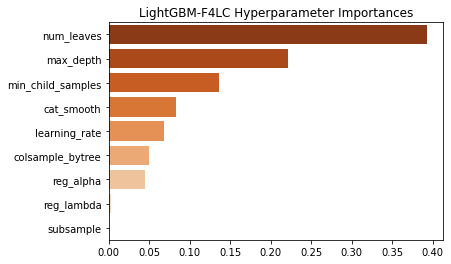

In [93]:
plot_hyperparameter_importances(lightgbm_f4lc_study)

In [94]:
lightgbm_f4lc_model = lgb.LGBMRegressor(metric="rmse", n_estimators=5000, random_state=42, **lightgbm_f4lc_study.best_params)

lightgbm_f4lc_model.fit(data_train[LIGHTGBM_F4LC_FEATURES], data_train.log_price_per_sqm)

LGBMRegressor(cat_smooth=56, colsample_bytree=0.6, learning_rate=0.03,
              max_depth=121, metric='rmse', min_child_samples=1,
              n_estimators=5000, num_leaves=515, random_state=42,
              reg_alpha=0.13020331134351731, reg_lambda=1.2937692395596345)

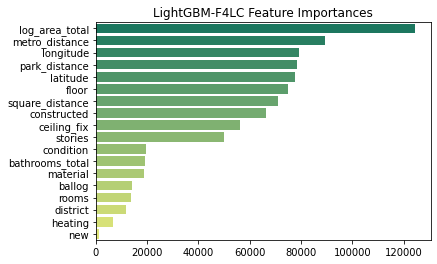

In [95]:
plot_feature_importances(LIGHTGBM_F4LC_FEATURES, lightgbm_f4lc_model.feature_importances_, "LightGBM-F4LC")

In [96]:
# Predict prices for the whole test set and write them to a correctly formatted CSV file
lightgbm_f4lc_prediction = np.exp(lightgbm_f4lc_model.predict(data_test[LIGHTGBM_F4LC_FEATURES])) * data_test.area_total
lightgbm_f4lc_prediction.rename("price_prediction").to_csv("submissions/lightgbm_f4lc.csv", index_label="id")

## Weighted Average of LightGBM-F4 and CatBoost-T2

Weighted by the cross-validation score of their best trial.

**TODO:** Estimation of the performance of this model...

In [97]:
pd.Series(
    np.average(
        [lightgbm_f4_prediction, catboost_t2_prediction],
        axis=0,
        weights=[-lightgbm_f4_study.best_value, -catboost_t2_study.best_value],
    ),
    index=lightgbm_f4_prediction.index,
    name="price_prediction",
).to_csv("submissions/weighted_average_lightgbm_f4_and_catboost_t2.csv", index_label="id")

## CatBoost-T2LC

In [98]:
CATBOOST_T2LC_FEATURES = LIGHTGBM_F4LC_FEATURES

In [99]:
def catboost_t2lc_objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 1, 1000),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
        "depth": trial.suggest_int("depth", 6, 14),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.001, 100.0),
        "random_strength": trial.suggest_int("random_strength", 0, 100),
        "bagging_temperature": trial.suggest_loguniform("bagging_temperature", 0.001, 100.0),
    }

    kf = sklearn.model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

    model = catboost.CatBoostRegressor(objective="RMSE", random_seed=42, silent=True, thread_count=1, **params)

    scores = []
    for train_idx, test_idx in kf.split(data_train[CATBOOST_T2LC_FEATURES], data_train.price):
        train, test = data_train.iloc[train_idx], data_train.iloc[test_idx]

        model.fit(train[CATBOOST_T2LC_FEATURES], train.log_price_per_sqm)

        predictions = np.exp(model.predict(test[CATBOOST_T2LC_FEATURES])) * test.area_total
        scores.append(rmsle(test.price, predictions))

    return np.mean(scores)

In [100]:
catboost_t2lc_study = optuna.create_study(
    storage=STORAGE,
    sampler=optuna.samplers.TPESampler(seed=42),
    study_name="CatBoost-T2LC",
    direction="minimize",
    load_if_exists=True
)

if not catboost_t2lc_study.trials:
    catboost_t2lc_study.optimize(catboost_t2lc_objective, n_trials=10)
else:
    print("Some trials have already been run, skipping further optimization.")

[I 2021-11-10 10:35:10,764] Using an existing study with name 'CatBoost-T2LC' instead of creating a new one.


Some trials have already been run, skipping further optimization.


In [101]:
pd.DataFrame.from_dict({
    "Number of completed trials": (catboost_t2lc_study.trials_dataframe().state == "COMPLETE").sum(),
    "Best trial": catboost_t2lc_study.best_trial.number,
    "Best value": catboost_t2lc_study.best_value,
}, orient="index", columns=[""])

,
Number of completed trials,100.000000
Best trial,91.000000
Best value,0.123653


In [102]:
pd.DataFrame.from_dict(catboost_t2lc_study.best_params, orient="index", columns=["Value"])

,Value
bagging_temperature,0.020690
depth,8.000000
iterations,995.000000
l2_leaf_reg,0.865703
learning_rate,0.129389
random_strength,3.000000


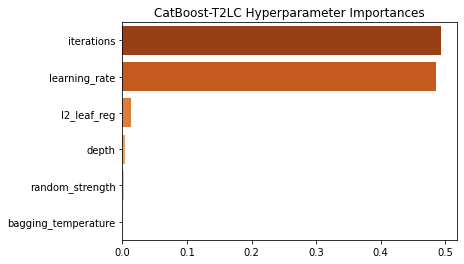

In [103]:
plot_hyperparameter_importances(catboost_t2lc_study)

In [104]:
catboost_t2lc_model = catboost.CatBoostRegressor(objective="RMSE", random_seed=42, silent=True, thread_count=1, **catboost_t2lc_study.best_params)

catboost_t2lc_model.fit(data_train[CATBOOST_T2LC_FEATURES], data_train.log_price_per_sqm)

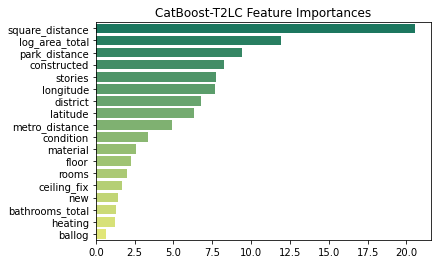

In [105]:
plot_feature_importances(CATBOOST_T2LC_FEATURES, catboost_t2lc_model.feature_importances_, "CatBoost-T2LC")

In [106]:
# Predict prices for the whole test set and write them to a correctly formatted CSV file
catboost_t2lc_prediction = np.exp(catboost_t2lc_model.predict(data_test[CATBOOST_T2LC_FEATURES])) * data_test.area_total
catboost_t2lc_prediction.rename("price_prediction").to_csv("submissions/catboost_t2lc.csv", index_label="id")

## Weighted Average of LightGBM-F4LC and CatBoost-T2LC

Weighted by the cross-validation score of their best trial.

**TODO:** Estimation of the performance of this model as well...

In [107]:
pd.Series(
    np.average(
        [lightgbm_f4lc_prediction, catboost_t2lc_prediction],
        axis=0,
        weights=[-lightgbm_f4lc_study.best_value, -catboost_t2lc_study.best_value],
    ),
    index=lightgbm_f4lc_prediction.index,
    name="price_prediction",
).to_csv("submissions/weighted_average_lightgbm_f4lc_and_catboost_t2lc.csv", index_label="id")

## TODO: LightGBM-F2

Dropping the `new` feature and changing the hyperparameters to be tuned.